In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.engine import engine, connectivity

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the transport network.
## Saves access and egress links for each zone.
## Needs all networks.


In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [4]:
road = stepmodel.read_json(model_path + 'de_road_network')

In [5]:
# Drop unused zones for later steps to work 
print(len(sm.zones.index))
sm.zones = sm.zones.loc[sm.zones['NUTS_ID'].str.startswith('DE')]
sm.zones = sm.zones[sm.zones["LEVL_CODE"]==3]
print(len(sm.zones.index))

467
467


## Assumptions

In [66]:
# Walking vs. driving to the train station
threshold = 500 # in m
speed_non_motorised_modes = 17 # in km/h
speed_car = 50 # in km/h
speed_footpaths = 5 # in km/h, assumed
# Max. distances for accessing the transport nodes
# in m
threshold_dict = {'road': 10000,
                  'road_pt': 500,
                  'pt': 25000,
                  'footpaths': 5000,
                  'footpaths_air': 10000,
                  'cycling_zones': 20000}

## Build access and egress links from zone centroids

In [11]:
# Compute controids
sm.preparation_ntlegs(
    zone_to_transit=False,
    zone_to_road=False)

In [12]:
# Compute road access and egress links
sm.zone_to_road = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids,
    road.road_nodes,
    short_leg_speed=speed_footpaths,
    long_leg_speed=speed_non_motorised_modes,
    threshold=threshold,
    n_neighbors=2,
    coordinates_unit=sm.coordinates_unit)
sm.zone_to_road = sm.zone_to_road.loc[
    sm.zone_to_road['distance']<=threshold_dict['road']]
len(sm.zone_to_road.index)

1864

In [13]:
# Compute road - PT links
sm.road_to_transit = engine.ntlegs_from_centroids_and_nodes(
    sm.nodes,
    road.road_nodes,
    short_leg_speed=speed_footpaths,
    long_leg_speed=speed_non_motorised_modes,
    threshold=threshold,
    n_neighbors=1,
    coordinates_unit=sm.coordinates_unit)
sm.road_to_transit = sm.road_to_transit.loc[
    sm.road_to_transit['distance']<=threshold_dict['road_pt']]
len(sm.road_to_transit.index)

3088

In [14]:
# Build PT connectors by route type
# Every route type is saved once in this attribute
assert len(sm.pt_route_types) == len(sm.links['route_type'].unique())
sm.pt_route_types

['rail_long', 'rail_short', 'coach', 'air', 'bus']

In [108]:
sm.zone_to_transit = sm.zone_to_transit.iloc[0:0]
for t in sm.pt_route_types:
    ntlegs = engine.ntlegs_from_centroids_and_nodes(
        sm.centroids,
        sm.nodes.loc[sm.nodes['route_type']==t],
        short_leg_speed=speed_footpaths,
        long_leg_speed=speed_car, # Take the car for longer trips
        threshold=threshold,
        n_neighbors=4,
        coordinates_unit=sm.coordinates_unit)
    # Cut off long links
    ntlegs = ntlegs.loc[ntlegs['distance']<=
                        threshold_dict['pt']]
    ntlegs['route_type'] = t
    sm.zone_to_transit = sm.zone_to_transit.append(ntlegs)
sm.zone_to_transit.reset_index(drop=True, inplace=True)
len(sm.zone_to_transit)

10502

In [109]:
# Remove connectors to other zones, if this zone
# has connection to the route type itself
ac = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access'].copy()
eg = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='eggress'].copy()
ac['node_FID'] = ac['b'].map(sm.nodes['FID'].to_dict())
eg['node_FID'] = eg['a'].map(sm.nodes['FID'].to_dict())

def filter_connectors(group, zone_col):
    if len(group['node_FID'].unique()) > 1: # Connection to more than one zone
        return group.loc[group['node_FID']==group[zone_col]]
    else: # Only has this one (or zero) zone connection
        return group
ac = ac.groupby(['route_type', 'a']).apply(filter_connectors, zone_col='a').reset_index(drop=True)
eg = eg.groupby(['route_type', 'b']).apply(filter_connectors, zone_col='b').reset_index(drop=True)

sm.zone_to_transit = pd.concat([ac, eg]).reset_index(drop=True).drop('node_FID', axis=1)

In [110]:
len(sm.zone_to_transit)

6134

## Generate footpaths table

In [71]:
sm.nodes.shape

(3218, 4)

In [83]:
# Uses the Voronoi algorithm (slow for more nodes than 1000)
# but good results
sm.preparation_footpaths(
    speed=speed_footpaths,
    max_length=threshold_dict['footpaths'],
    n_clusters=3000)

In [ ]:
# Generate footpaths between modes manually
'''sm.footpaths = sm.footpaths.iloc[0:0]
for o in ['rail_short_distance', 'bus']:
    for d in [t for t in sm.pt_route_types if t!='bus']:
        if o != d:
            ntlegs = engine.ntlegs_from_centroids_and_nodes(
                sm.nodes.loc[sm.nodes['route_type']==o],
                sm.nodes.loc[sm.nodes['route_type']==d],
                short_leg_speed=speed_footpaths,
                long_leg_speed=speed_non_motorised_modes,
                threshold=threshold,
                n_neighbors=1,
                coordinates_unit=sm.coordinates_unit)
            if d == 'air':
                ntlegs = ntlegs.loc[ntlegs['distance']<=
                                    threshold_dict['footpaths_air']]
            else:
                ntlegs = ntlegs.loc[ntlegs['distance']<=
                                    threshold_dict['footpaths']]
            sm.footpaths = sm.footpaths.append(ntlegs)'''
print('Manual version')

In [84]:
len(sm.footpaths)

9850

In [85]:
# Number of nodes that overlay each other
sm.footpaths.loc[sm.footpaths['length']==0].shape

(5520, 6)

In [79]:
# Generate footpaths between centroids
ntlegs = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids,
    sm.centroids,
    short_leg_speed=speed_non_motorised_modes,
    long_leg_speed=speed_non_motorised_modes,
    threshold=threshold,
    n_neighbors=2,
    coordinates_unit=sm.coordinates_unit)
ntlegs = ntlegs.loc[ntlegs['distance']<=
                    threshold_dict['cycling_zones']]
ntlegs = ntlegs.loc[ntlegs['distance']!=0]
ntlegs.drop_duplicates(['direction', 'distance', 'time'], inplace=True)
ntlegs.shape

(338, 11)

In [87]:
sm.footpaths = sm.footpaths.append(ntlegs.rename(
    columns={'distance':'length', 'rank':'voronoi'})[sm.footpaths.columns])

In [88]:
# Reindex
sm.footpaths.reset_index(drop=True, inplace=True)
sm.footpaths.index = 'foot_' + pd.Series(sm.footpaths.index).astype(str)

In [89]:
sm.footpaths.sample(2)

,a,b,geometry,length,voronoi,time
foot_7193,rail_long_node_10,rail_long_node_568,"LINESTRING (8.25872 50.001118, 8.25872 50.001118)",0.000000,0,0.000000
foot_181,rail_long_node_491,coach_node_FLIXBUS:37,"LINESTRING (10.062634 52.620964, 10.06316 52.6...",124.590335,1,89.705041


## Parametrise access and egress links

In [90]:
# Road - PT connectors
sm.road_to_transit['distance'] = 0
sm.road_to_transit['time'] = 5*60 # in seconds
sm.road_to_transit.sample(n=2)

,a,b,direction,distance,geometry,rank,speed_factor,short_leg_speed,long_leg_speed,speed,time
6105,246898843,DEA32_bus_1,eggress,0,LINESTRING (7.082539480140458 51.5064848598143...,0,0.676066,5,17,5.0,300
6369,56315846,DE944_r_s_2,eggress,0,"LINESTRING (8.045902 52.280933, 8.043416499999...",0,0.631417,5,17,5.0,300


In [91]:
# Road - centroid connectors
sm.zone_to_road['distance'] = 0
sm.zone_to_road['time'] = 0
sm.zone_to_road.sample(n=2)

,a,b,direction,distance,geometry,rank,speed_factor,short_leg_speed,long_leg_speed,speed,time
1587,1577186923,DEA22,eggress,0,LINESTRING (7.109821750887605 50.7058252224767...,1,1.796515,5,17,8.982573,0
756,DEA13,2372131880,access,0,LINESTRING (7.016953026028951 51.4339143034858...,1,0.673689,5,17,5.000000,0


In [92]:
# Zone to PT:
# Load distances to PT stops from census data
clusters = pd.read_csv(input_path + 'spatial_census_refined_FID.csv')
clusters.set_index('index', inplace=True)
dist_col = 'weighted_dist'
mean_dist_col = 'mean_weighted_dist'
cent_col = 'cluster_center'
#pop_col = 'population'
node_col = 'node_id'

In [93]:
clusters['NUTS_ID'] = clusters['FID'].apply(lambda s: str(s).split('_')[0])

In [94]:
# Create a zone - distance - type dict
# Take the mean weighted distance, assume population shares are about equal
zone_type_dist = clusters.groupby(['NUTS_ID', 'route_type']).agg(
    {mean_dist_col: 'mean'})#.to_dict()[mean_dist_col]
zone_type_dist

mean_weighted_dist
NUTS_ID route_type                             
DE111   bus                         7534.073525
        coach                       8431.291442
        rail_long_distance         10573.888593
        rail_short_distance        15243.095365
DE112   bus                        26148.499516
...                                         ...
DEG0N   coach                       5397.254430
        rail_long_distance          4194.575713
        rail_short_distance         5539.621888
DEG0P   bus                        10844.458205
        rail_short_distance        23040.377472

[1248 rows x 1 columns]

In [111]:
# Split legs into access and egress
access = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access'].copy()
egress = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='eggress'].copy()# name in quetzal

In [112]:
# Alter the distance
route_types = clusters['route_type'].unique()
for t in route_types:
    for zone in list(sm.zones['NUTS_ID']):
        try:
            access.loc[(access['route_type']==t) & (access['a']==zone),
                       'distance'] = zone_type_dist.loc[(zone, t), mean_dist_col]
        except KeyError:
            # There is no such station in this zone
            access.loc[(access['route_type']==t) & (access['a']==zone),
                       'distance'] = np.nan
for t in route_types:
    for zone in list(sm.zones['NUTS_ID']):
        try:
            egress.loc[(egress['route_type']==t) & (egress['b']==zone),
                       'distance'] = zone_type_dist.loc[(zone, t), mean_dist_col]
        except KeyError:
            # There is no such station in this zone
            egress.loc[(egress['route_type']==t) & (egress['b']==zone),
                       'distance'] = np.nan

In [113]:
sm.zone_to_transit = access.append(egress)

In [114]:
len(sm.zone_to_transit.loc[sm.zone_to_transit['distance'].isna()])

176

<AxesSubplot:>

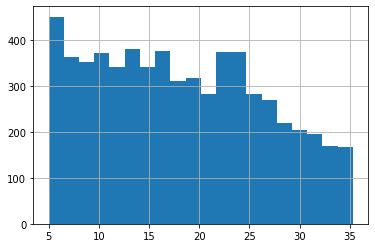

In [115]:
sm.zone_to_transit['speed'].hist(bins=20)

In [116]:
# Alter time of PT legs
sm.zone_to_transit['time'] = sm.zone_to_transit['distance'] / \
    sm.zone_to_transit['speed'] * 3.6 # in s
sm.zone_to_transit['time'].replace({np.nan: threshold_dict['pt']/speed_car}, inplace=True)

In [117]:
# Replace NaN
sm.zone_to_transit.loc[sm.zone_to_transit['distance'].isna(), 'distance'] = 0
sm.zone_to_transit.loc[sm.zone_to_transit['speed'].isna(), 'speed'] = 0

In [118]:
print(len(sm.zone_to_transit))
sm.zone_to_transit.sample()

6134


,a,b,direction,distance,geometry,long_leg_speed,rank,route_type,short_leg_speed,speed,speed_factor,time,walk_time
3532,DE80J_1_bus_1,DE80J_1,eggress,22721.041801,LINESTRING (13.27547582863626 53.5880001954110...,50,1,bus,5,33.705372,6.741074,2426.786772,NaN


<AxesSubplot:>

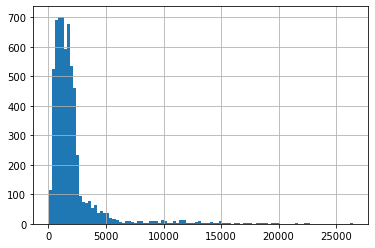

In [119]:
sm.zone_to_transit['time'].hist(bins=100)

In [120]:
# Ditch all legs which take too long
sm.zone_to_transit = sm.zone_to_transit.loc[sm.zone_to_transit['time']<5400]
len(sm.zone_to_transit)

5830

## Save model

In [125]:
# Drop unneccessary columns
cols = ['speed_factor', 'short_leg_speed', 'long_leg_speed', 'rank', 'voronoi', 'walk_time']
sm.footpaths.drop(cols, axis=1, inplace=True, errors='ignore')
sm.zone_to_transit.drop(cols, axis=1, inplace=True, errors='ignore')

In [126]:
sm.zone_to_road.drop(cols, axis=1, inplace=True, errors='ignore')
sm.road_to_transit.drop(cols, axis=1, inplace=True, errors='ignore')

In [128]:
# Make tables lighter
cols = ['distance', 'speed', 'time']
sm.zone_to_transit[cols] = sm.zone_to_transit[cols].astype(int)
sm.zone_to_road[cols] = sm.zone_to_road[cols].astype(int)
sm.road_to_transit[cols] = sm.road_to_transit[cols].astype(int)
try:
    sm.footpaths[cols] = sm.footpaths[cols].astype(int)
except KeyError:
    cols = ['length', 'time']
    sm.footpaths[cols] = sm.footpaths[cols].astype(int)

In [129]:
sm.footpaths.sample()

,a,b,geometry,length,time
foot_6623,rail_long_node_354,rail_long_node_1227,"LINESTRING (13.388513 52.54896, 13.388513 52.5...",0,0


In [131]:
# Saving model...
tables = ['centroids', 'footpaths', 'zone_to_transit']
sm.to_json(model_path + 'de_pt_access_egress',
           only_attributes=tables, encoding='utf-8')


to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.56it/s]


In [132]:
sm.to_json(model_path + 'de_road_access_egress',
           only_attributes=['centroids', 'zone_to_road', 'road_to_transit'],
           encoding='utf-8')


to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 38.71it/s]
